# Causal Inference Project:

### Olist Brazilian Ecommerce Store

----

### About Olist and Dataset

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.


**Data Schema**

<img src="/Users/juanherrera/Desktop/causal-attribution-analysis/resources/pictures/data-schema.png" alt="Alt Text" width="700"/>

**Marketing Data and how to link with orders data**


<img src="/Users/juanherrera/Desktop/causal-attribution-analysis/resources/pictures/marketing-data-schema.png" alt="marketing-data-schema" width="700"/>

**Example Order Listed**

<img src="/Users/juanherrera/Desktop/causal-attribution-analysis/resources/pictures/example-order-listed-marketplace.png" alt="Alt Text" width="700"/>

---


# Potential Research Question

### 1. What is the causal effect of delivery time on customer satisfaction ratings?
- Followed by root-cause analysis (attribution model) to understand what are the factors we can attribute the delays in delivery



Other Alternatives we could explore

2. How does the number of product photos impact sales performance?
3. What is the causal impact of price discounts on order frequency and customer retention?
4. How does seller location relative to customers affect order fulfillment time and customer satisfaction?
5. What is the causal effect of payment method on the likelihood of a customer leaving a review?
6. How does the success rate of closing deals with marketing qualified leads impact seller performance?
7. What is the causal impact of product category on delivery delays?
8. How does the timing of customer reviews affect future sales for a seller?

# Steps in the Analysis

1. Model a causal inference problem using assumptions.
2. Identify an expression for the causal effect under these assumptions (“causal estimand”)
3. Estimate the expression using statistical methods such as matching or instrumental variables
4. Finally, verify the validity of the estimate using a variety of robustness checks

----

In [74]:
# Imports
import pandas as pd # type: ignore
import numpy as np # type: ignore

# viz
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
import networkx as nx # type: ignore

# utils
from utils import load_data

pd.set_option('display.max_columns', None)

# Loading Data



---

**olist_customers_df**

This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.

At our system each order is assigned to a unique customer_id. This means that the same customer will get different ids for different orders. The purpose of having a customer_unique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.

---

**olist_geolocation_df**

This dataset has information Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.

---

**olist_order_items_df**

This dataset includes data about the items purchased within each order.

Example:
The order_id = 00143d0f86d6fbd9f9b38ab440ac16f5 has 3 items (same product). Each item has the freight calculated accordingly to its measures and weight. To get the total freight value for each order you just have to sum.

The total order_item value is: 21.33 * 3 = 63.99

The total freight value is: 15.10 * 3 = 45.30

The total order value (product + freight) is: 45.30 + 63.99 = 109.29

---

**olist_order_payments_df**

This dataset includes data about the orders payment options.

---

**olist_order_reviews_df**

This dataset includes data about the reviews made by the customers.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

---

**olist_orders_df**

This is the core dataset. From each order you might find all other information.

---

**olist_products_df**

This dataset includes data about the products sold by Olist.

---

**olist_sellers_df**

This dataset includes data about the sellers that fulfilled orders made at Olist. Use it to find the seller location and to identify which seller fulfilled each product.


---

**olist_closed_deals_df**

After a qualified lead fills in a form at a landing page he is contacted by a Sales Development Representative. At this step some information is checked and more information about the lead is gathered.

---
**olist_marketing_qualified_leads_df**

After a lead fills in a form at a landing page, a filter is made to select the ones that are qualified to sell their products at Olist. They are the Marketing Qualified Leads (MQLs).


In [75]:
# Loading Data
data_dict = load_data()

olist_customers_df = data_dict['olist_customers_df']
olist_geolocation_df = data_dict['olist_geolocation_df']
olist_order_items_df = data_dict['olist_order_items_df']
olist_order_payments_df = data_dict['olist_order_payments_df']
olist_order_reviews_df = data_dict['olist_order_reviews_df']
olist_orders_df = data_dict['olist_orders_df']
olist_products_df = data_dict['olist_products_df']
olist_sellers_df = data_dict['olist_sellers_df']
product_category_name_translation_df = data_dict['product_category_name_translation_df']

olist_closed_deals_df = data_dict['olist_closed_deals_df']
olist_marketing_qualified_leads_df = data_dict['olist_marketing_qualified_leads_df']

In [76]:
print("Datasets & Columns")
for df_name, dataframe in data_dict.items():
    print("-"*100)
    print("-" * 10, df_name)

    for col in dataframe.columns:
        print(col)

Datasets & Columns
----------------------------------------------------------------------------------------------------
---------- olist_customers_df
customer_id
customer_unique_id
customer_zip_code_prefix
customer_city
customer_state
----------------------------------------------------------------------------------------------------
---------- olist_geolocation_df
geolocation_zip_code_prefix
geolocation_lat
geolocation_lng
geolocation_city
geolocation_state
----------------------------------------------------------------------------------------------------
---------- olist_order_items_df
order_id
order_item_id
product_id
seller_id
shipping_limit_date
price
freight_value
----------------------------------------------------------------------------------------------------
---------- olist_order_payments_df
order_id
payment_sequential
payment_type
payment_installments
payment_value
----------------------------------------------------------------------------------------------------
-------

In [77]:
# Merge into one dataset 
# ToDo: turn into function

df = olist_orders_df.merge(olist_order_items_df, on='order_id', how='left')
df = df.merge(olist_order_payments_df, on='order_id', how='outer', validate='m:m')
df = df.merge(olist_order_reviews_df, on='order_id', how='outer')
df = df.merge(olist_products_df, on='product_id', how='outer')
df = df.merge(olist_customers_df, on='customer_id', how='outer')
df = df.merge(olist_sellers_df, on='seller_id', how='outer')

# Joining marketing data
df = df.merge(olist_closed_deals_df, on='seller_id', how='left')
df = df.merge(olist_marketing_qualified_leads_df, on='mql_id', how='left')

### Exploratory Data Analysis

In [54]:
olist_orders_df['order_delivered_customer_date'] = pd.to_datetime(olist_orders_df['order_delivered_customer_date'])
olist_orders_df['order_estimated_delivery_date'] = pd.to_datetime(olist_orders_df['order_estimated_delivery_date'])

In [55]:
olist_orders_df['late_delivery_in_days'] = (olist_orders_df['order_delivered_customer_date'] \
                                            - olist_orders_df['order_estimated_delivery_date']).dt.days

In [57]:
# if late_delivery_in_days > 0, then delivery was late
olist_orders_df['is_delivery_late'] = np.where(olist_orders_df['late_delivery_in_days'] > 0, 1, 0)

In [59]:
olist_orders_df['is_delivery_late'].value_counts()

is_delivery_late
0    92906
1     6535
Name: count, dtype: int64

In [68]:
temp_df = olist_orders_df.merge(olist_order_reviews_df, on='order_id', how='left')
temp_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,late_delivery_in_days,is_delivery_late,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8.0,0,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6.0,0,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18.0,0,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13.0,0,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10.0,0,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51


In [71]:
temp_df[temp_df['is_delivery_late'] == 1]['review_score'].mean()

np.float64(2.271138845553822)

In [72]:
temp_df[temp_df['is_delivery_late'] == 0]['review_score'].mean()

np.float64(4.211789169737324)

----

### **Step 1**: Construct Directed Acyclic Graphs (DAG)

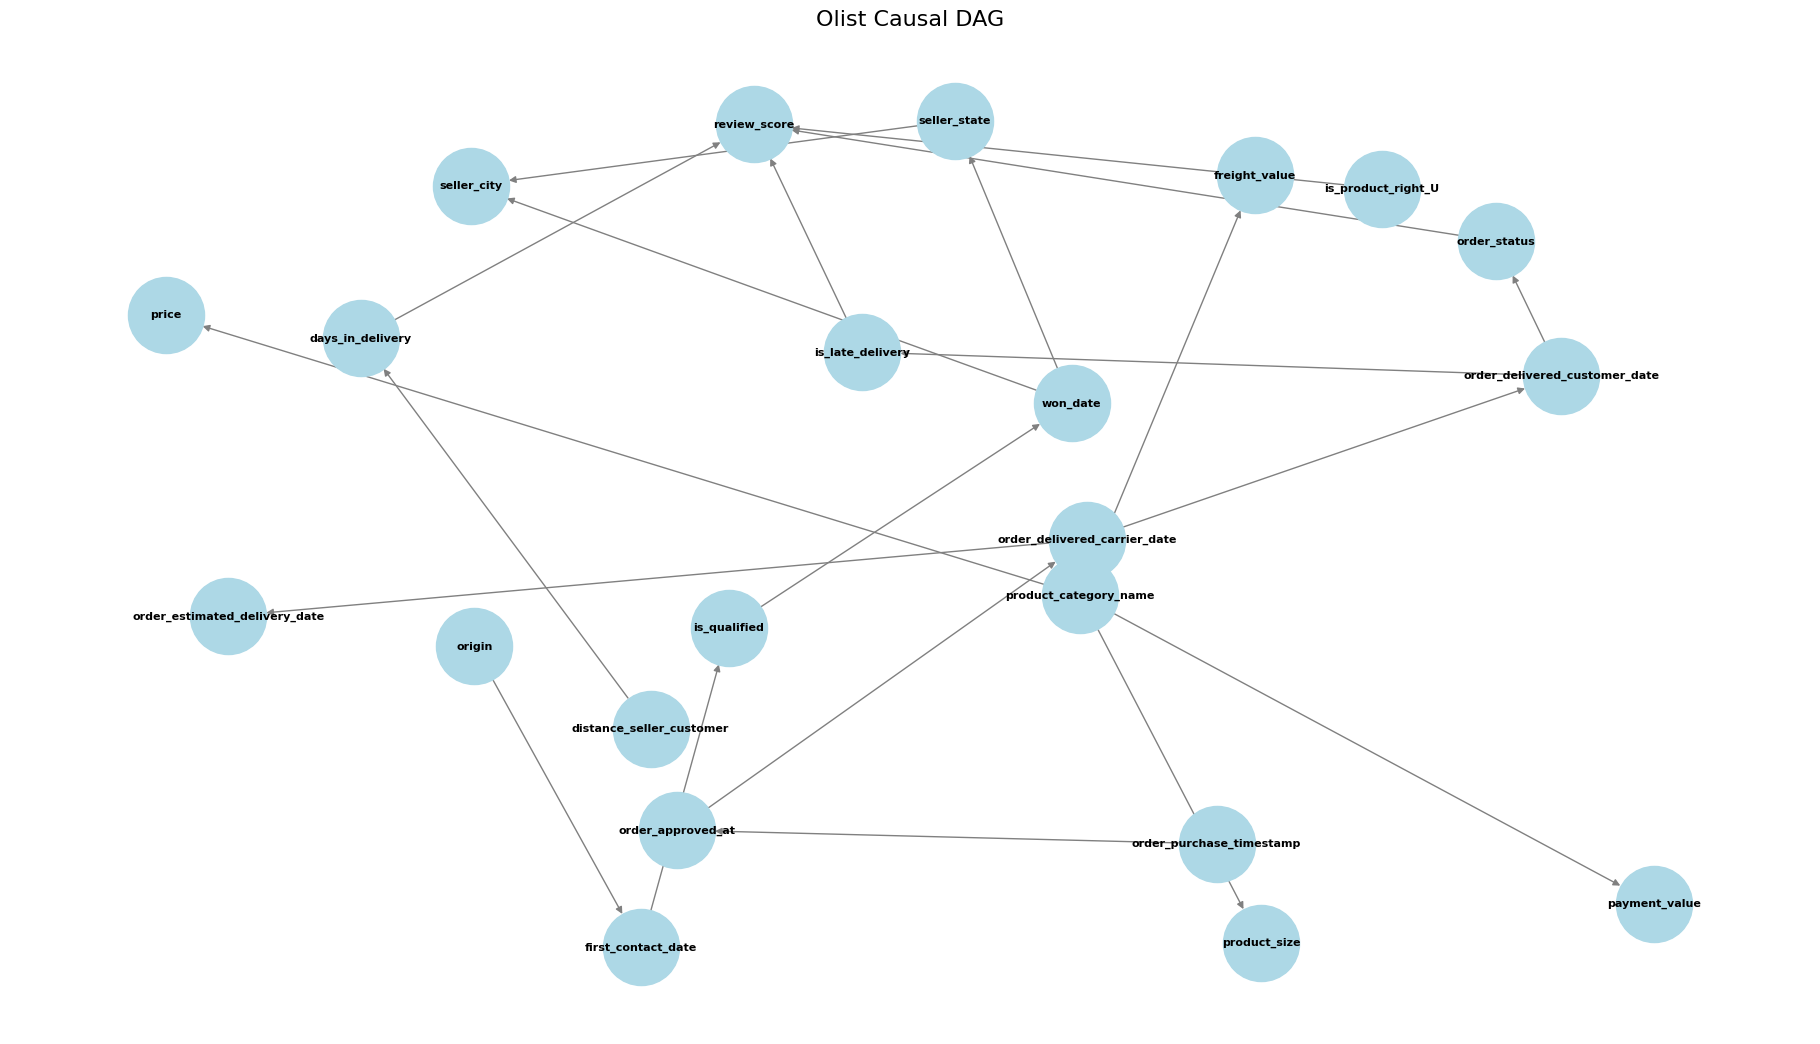

In [84]:
# Create a new directed graph
G = nx.DiGraph()


# Add nodes
nodes = [
    "origin", "first_contact_date", "is_qualified", "won_date", "seller_state",
    "seller_city", "product_category_name", "product_size",
    "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date",
    "order_delivered_customer_date", "order_estimated_delivery_date", "order_status",
    "review_score", "payment_value", "product_category_name", "price", "freight_value",
    "distance_seller_customer", "days_in_delivery", "is_late_delivery", "is_product_right_U"

]
G.add_nodes_from(nodes)


# Add edges (relationships)
edges = [
    ("origin", "first_contact_date"),
    ("first_contact_date", "is_qualified"),
    ("is_qualified", "won_date"),
    ("won_date", "seller_state"),
    ("won_date", "seller_city"),
    ("seller_state", "seller_city"),
    ("product_category_name", "product_size"),
    ("order_purchase_timestamp", "order_approved_at"),
    ("order_approved_at", "order_delivered_carrier_date"),
    ("order_delivered_carrier_date", "order_delivered_customer_date"),
    ("order_delivered_carrier_date", "order_estimated_delivery_date"),
    ("order_delivered_customer_date", "order_status"),
    ("order_delivered_customer_date", "is_late_delivery"),
    ("is_late_delivery", "review_score"),
    ("order_status", "review_score"),
    ("days_in_delivery", "review_score"),
    ("is_product_right_U", "review_score"),
    ("product_category_name", "payment_value"),
    ("product_category_name", "price"),
    ("product_category_name", "freight_value"),
    ("distance_seller_customer", "days_in_delivery")


]
G.add_edges_from(edges)

# Set up the plot
plt.figure(figsize=(18, 10))
pos = nx.spring_layout(G, k=0.9, iterations=50)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=8, font_weight='bold', 
        arrows=True, edge_color='gray')

# Add edge labels
edge_labels = {(u, v): '' for (u, v) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# Show the plot
plt.title("Olist Causal DAG", fontsize=16)
plt.axis('off')
plt.show()



### Simplified DAG

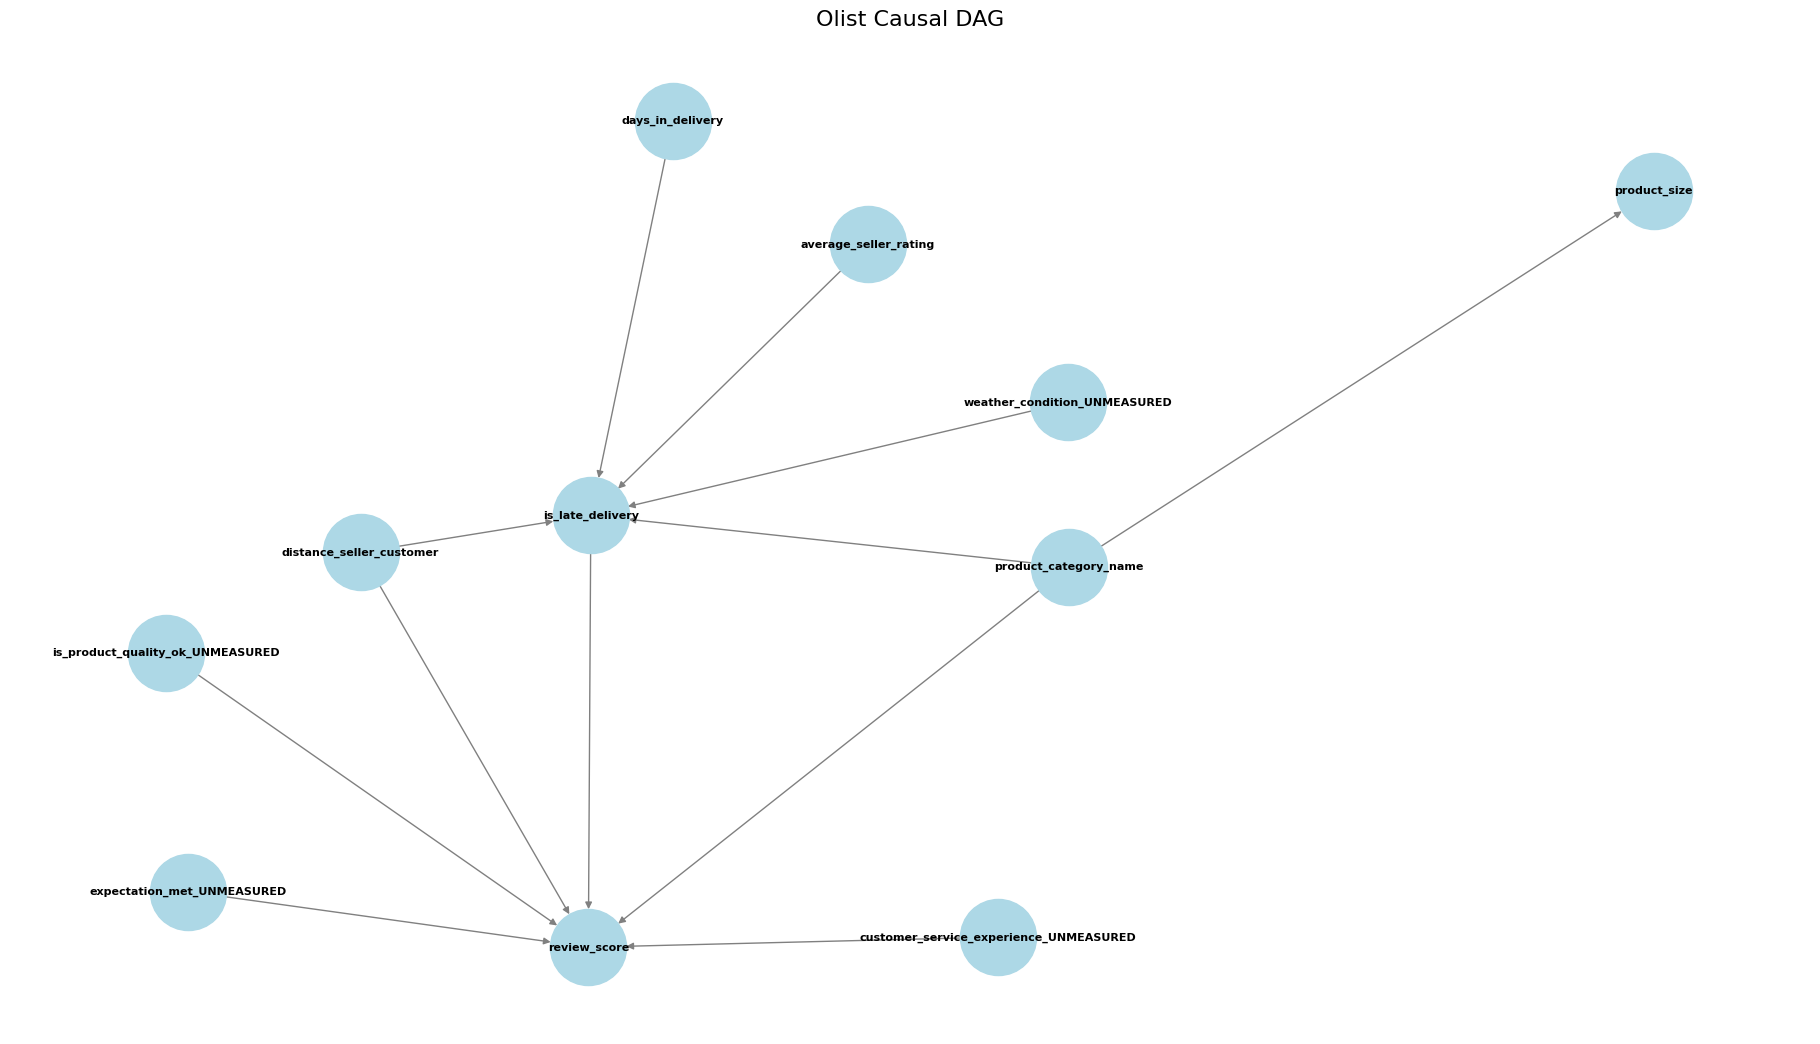

In [93]:
# Create a new directed graph
G = nx.DiGraph()


# Add nodes
nodes = [
    "is_late_delivery",
    "review_score",
    "distance_seller_customer",
    "product_category_name",
    "product_size",
    "days_in_delivery",
    "average_seller_rating",
    "is_product_quality_ok_UNMEASURED",
    "customer_service_experience_UNMEASURED",
    "expectation_met_UNMEASURED"

]
G.add_nodes_from(nodes)


# Add edges (relationships)
edges = [
    ("is_late_delivery", "review_score"),
    ("distance_seller_customer", "is_late_delivery"),
    ("distance_seller_customer", "review_score"),
    ("product_category_name", "is_late_delivery"),
    ("product_category_name", "review_score"),
    ("product_category_name", "product_size"),
    ("days_in_delivery", "is_late_delivery"),
    ("is_product_quality_ok_UNMEASURED", "review_score"),
    ("customer_service_experience_UNMEASURED", "review_score"),
    ("expectation_met_UNMEASURED", "review_score"),
    ("weather_condition_UNMEASURED", "is_late_delivery"),
    ("average_seller_rating", "is_late_delivery")

]
G.add_edges_from(edges)

# Set up the plot
plt.figure(figsize=(18, 10))
pos = nx.spring_layout(G, k=0.9, iterations=50)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=8, font_weight='bold', 
        arrows=True, edge_color='gray')

# Add edge labels
edge_labels = {(u, v): '' for (u, v) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# Show the plot
plt.title("Olist Causal DAG", fontsize=16)
plt.axis('off')
plt.show()

-----

# Links

- Factors contributing to writing bad reviews: https://amazon-asin.com/blog/amazon-negative-reviews/#:~:text=Amazon's%20bad%20reviews%20often%20stem,discrepancies%20in%20the%20product%20description.